# Lab 4: Basic regression - Predict fuel efficiency



## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # we use this library to load the dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [2]:
# Load the 'mpg' dataset using seaborn library into a Pandas DataFrame
df = sns.load_dataset('mpg')

MPG dataset can be viewed online at  
https://github.com/mwaskom/seaborn-data/blob/master/mpg.csv

## Data Exploration - Pandas Review

### Show the first 5 rows of the dataset

In [3]:
#your code here
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


### Show the size of the dataframe

In [4]:
#your code here
df.shape

(398, 9)

### Find the columns name and their types (numerical or categorical)

In [5]:
#your code here
df.dtypes

,0
mpg,float64
cylinders,int64
displacement,float64
horsepower,float64
weight,int64
acceleration,float64
model_year,int64
origin,object
name,object


### Find the number of missing values in each column

In [6]:
#your code here
df.isnull().sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
name,0


### Handle the missing values in the dataframe

Since the number of missing values is low, we can simply drop the rows containing them. However, as a practice and review, let's substitute the missing values in the numerical columns (if any) with the mean of the respective column and the missing values in the categorical columns (if any) with the median of the respective column.

In [7]:
#your solution here
df.dropna(inplace=True)

### Compute the average and the median weight

In [9]:
#your code here
mean_weight = df['weight'].mean()
median_weight = df['weight'].median()

print("Mean weight:", mean_weight)
print("Median weight:", median_weight)

Mean weight: 2977.5841836734694
Median weight: 2803.5


### Find the number of cars that weight more than 2000 kgs

In [10]:
#your code here
df[df['weight'] > 2000].shape[0]

349

### Find how many cars there are for each number of cylinders

In [11]:
#your code here
df['cylinders'].value_counts()

,count
cylinders,
4,199
8,103
6,83
3,4
5,3


### Find what are the car models with number of cylinders (3 or 5)

In [12]:
#your code here
df[(df['cylinders'] == 3) | (df['cylinders'] == 5)]['model_year']

,model_year
71,72
111,73
243,77
274,78
297,79
327,80
334,80


### Show the `value_counts()` of `origin` column or show the unique values of this column.

In [13]:
#your code here
df['origin'].value_counts()

,count
origin,
usa,245
japan,79
europe,68


## Data Preprocessing

### Use one hot encoding to change the categorical values of `origin` column to numerical values.

- use `pd.get_dummies()` method to do the encoding
- Join the original DataFrame with the new dummy DataFrame with `pd.concat()` and use `axis=1` to concate in horizontal direction.

In [14]:
#your code here
df = pd.concat([df, pd.get_dummies(df['origin'], prefix='origin')], axis=1)

### Remove the `name` and `origin` column form the dataframe to have all numerical dataframe.

In [15]:
#your code here
df.drop(['name', 'origin'], axis=1, inplace=True)

### Does the input needs reshaping?

In [16]:
#your code here
df.shape

(392, 10)

### Form features `X` and labels `y` based on the processed datafram

In [17]:
#your code here
X = df.drop('mpg', axis=1)
y = df['mpg']

### Split the data into training and test sets and form `train_features`, `train_labels`, `test_features`, `test_labels`

In [18]:
from sklearn.model_selection import train_test_split
#your code here
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

### For simplicity in the following steps, convert the dataset from a pandas DataFrame to a numpy array.

In [19]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

### Do some sanity check on the shape of the data before building a model

In [20]:
# your code here
print(train_features.shape)
print(train_labels.shape)

(313, 9)
(313,)


## Normalization layer

To ensure stable training of neural networks, we typically normalize the data. This process also enhances the convergence of the gradient descent algorithm.

There is not single way to normalize the data. You can also use `scikit-learn `or `pandas` to do it. However, in this lab, we will use the normalization layer provided by tensorflow which matches the other parts of the model.

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [21]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`.

It calculates the mean and variance of each feature, and store them in the layer

In [22]:
normalizer.adapt(train_features)

When the layer is called, it returns the input data, with each feature independently normalized.

In [48]:
first = train_features[0]
print('First example:', first)
print()
print('Normalized:', normalizer(first.astype(float)).numpy())

First example: [6 225.0 110.0 3620 18.7 78 False False True]

Normalized: [[ 0.3048616   0.2845775   0.14142872  0.7548031   1.1217592   0.4945284
  -0.42559615 -0.50199604  0.74128604]]


## **Approach #1:** Regression using `Linear Regression`

**You are welcome to use scikit-learn to perform linear regression on this dataset.**

However, here we aim to implement it using TensorFlow.

- As we saw in Lab Week 2, `logistic regression` is essentially a single neuron with a `sigmoid` activation function.

- Similarly, `linear regression` can be viewed as a single neuron with a `linear` activation function.

### **Step 1:** Linear regression model architecture

In [25]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(9,)),
    normalizer,
    layers.Dense(1, activation='linear')
])

**Note:** You can define your model all at once like the cell above or you can buid the model incrementaly  (suitable for your assignment)

In [26]:
# Defining the model incrementaly (suitable for your assignment)
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Input(shape=(9,)))
linear_model.add(normalizer)
linear_model.add(layers.Dense(1, activation='linear'))

### **Step 2:** Configure the model with Keras `Model.compile()`

The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`"mean_absolute_error"`) and how (using the `tf.keras.optimizers.Adam(learning_rate=0.1)`).

**arguments:**
- optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
- loss='mean_absolute_error'

In [29]:
#your code here
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                     loss='mean_absolute_error')



### **Step 3:** Train the model using the `Model.fit()` for `100` epochs, and store the output in a variable named history.

In [31]:
history = linear_model.fit(train_features.astype(float), train_labels, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 23.0994
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.3506 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.2989 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.4919 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1647 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2423 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.3480 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.1955 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7172 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.7564 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.3050 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0155 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5503 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2132 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [32]:
history.history

{'loss': [23.19840431213379,
  22.22797393798828,
  21.182966232299805,
  20.17551612854004,
  19.17668914794922,
  18.17615509033203,
  17.183019638061523,
  16.198875427246094,
  15.190966606140137,
  14.198939323425293,
  13.208562850952148,
  12.222458839416504,
  11.26547622680664,
  10.234142303466797,
  9.2696533203125,
  8.241312980651855,
  7.257190227508545,
  6.316922664642334,
  5.445253372192383,
  4.644680023193359,
  3.9739561080932617,
  3.4306585788726807,
  3.06717848777771,
  2.829596757888794,
  2.6948530673980713,
  2.6083860397338867,
  2.570131301879883,
  2.54239559173584,
  2.5350699424743652,
  2.5125558376312256,
  2.544901132583618,
  2.5260097980499268,
  2.5285446643829346,
  2.521256923675537,
  2.511617660522461,
  2.5220284461975098,
  2.5132551193237305,
  2.5020694732666016,
  2.5290122032165527,
  2.505277156829834,
  2.4946630001068115,
  2.50358510017395,
  2.5189032554626465,
  2.523146629333496,
  2.511129856109619,
  2.4897024631500244,
  2.5086

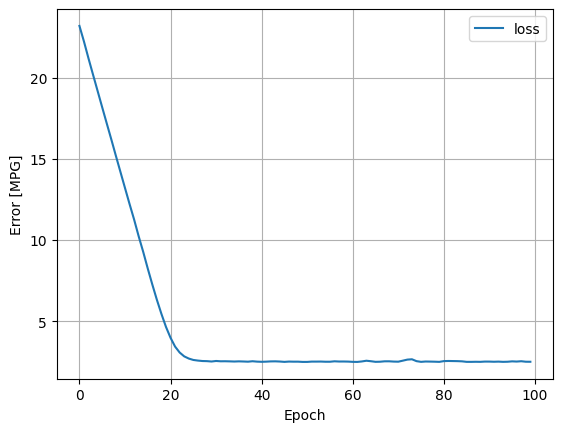

In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

### Get the model summary

In [34]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (212.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 22 (92.00 B)

### **Step 4:** Evaluate the linear model on the test set using Keras `Model.evaluate()` and see the `mean_absolute_error` and save the result for future comparison.

In [36]:
#your code here
test_loss = linear_model.evaluate(test_features.astype(float), test_labels)
mean_absolute_error = test_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4157


## **Approach #2:** Regression using a `Deep Neural Network (DNN)`

### Solve the same problem and using deep neural network with the sample architecture;
- 1st hidden layer no. of units =  64
- 2nd hidden layer no. of units = 64
- Choose appropriate `activation` functions for hidden and output layers

In [40]:
#your code here
model_dnn = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [49]:
model_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

history_dnn = model_dnn.fit(
    train_features.astype(float), train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

dnn_test_mae = model_dnn.evaluate(test_features.astype(float), test_labels, verbose=0)
print("DNN test MAE:", dnn_test_mae)
print(model_dnn.summary())


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 23.2503 - val_loss: 24.0320
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.3970 - val_loss: 23.2853
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.4271 - val_loss: 22.4028
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.1636 - val_loss: 21.2958
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2194 - val_loss: 19.8574
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.7275 - val_loss: 17.9878
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.8662 - val_loss: 15.6294
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.8330 - val_loss: 13.1262
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.6201 - val_loss: 10.3897
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6345 - val_loss: 7.5076
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6291 - val_loss: 6.4031
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8760 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,616 (57.10 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 9,732 (38.02 KB)

None


### Print the model summary (after training). How many parameters are there in the model?

In [51]:
print(model_dnn.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,616 (57.10 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 9,732 (38.02 KB)

None


## Compare the evaluation result of the two approaches, i.e., linear regression and deep neural network.

In [52]:
#your code here
print("Mean absolute error for linear regression: ", mean_absolute_error)
print("Mean absolute error for deep neural network: ", test_loss)


Mean absolute error for linear regression:  2.440945863723755
Mean absolute error for deep neural network:  2.440945863723755


## Use the following large model and evaluate it on the test set.

In [53]:
model_dnn_large = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


In [54]:
# your code here
model_dnn_large


<Sequential name=sequential_4, built=False>

In [55]:
model_dnn_large.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

history_large = model_dnn_large.fit(
    train_features.astype(float), train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

large_test_mae = model_dnn_large.evaluate(test_features.astype(float), test_labels, verbose=0)
print("Large DNN test MAE:", large_test_mae)
print(model_dnn_large.summary())


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 23.3109 - val_loss: 24.2367
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.6449 - val_loss: 22.9945
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.0372 - val_loss: 20.4642
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.8544 - val_loss: 15.7895
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.1005 - val_loss: 9.5804
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9995 - val_loss: 7.1675
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7520 - val_loss: 5.0237
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6836 - val_loss: 4.1988
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5258 - val_loss: 3.5305
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1898 - val_loss: 3.6081
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1432 - val_loss: 2.9709
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8068 - val_lo

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,576 (154.60 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 26,372 (103.02 KB)

None


### Explain your observation. Why do you think the large model is not performing well?

- hint: when the number of trainable parameters is very large (even larger than the number of data points), the model may overfit the training data. One way to solve this problem is to use more data.

**Ans:**

The large model has too many trainable parameters compared to the size of the dataset, causing it to overfit the training data. Instead of learning general patterns, it memorizes the training samples, which leads to poor performance on validation and test data. A smaller model or more training data would help improve generalization.
